In [1]:
import copy
import glob

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

from IPython.display import HTML

import astropy.table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import AsymmetricPercentileInterval, ImageNormalize, LogStretch
from astropy.io import fits
from astropy.modeling.models import Gaussian1D
from astropy.modeling import fitting,models
from astropy.stats import gaussian_fwhm_to_sigma

import sunpy.map
import sunpy.timeseries
import sunpy.sun.constants
from sunpy.coordinates import Helioprojective
from sunpy.map.maputils import all_coordinates_from_map, coordinate_is_on_solar_disk
from sunpy.coordinates import frames

import math

import time

from scipy import optimize

In [39]:
AIA_filename="data/AIA/aia_lev1_304a_2011_01_27t22_58_56_12z_image_lev1.fits"
m_aia=sunpy.map.Map(AIA_filename)
image_data=m_aia.data
image_shape_x,image_shape_y=m_aia.data.shape

In [81]:
wavelength_list=np.linspace(-0.1,0.15,14)
intensity=irradiance(wavelength_list)

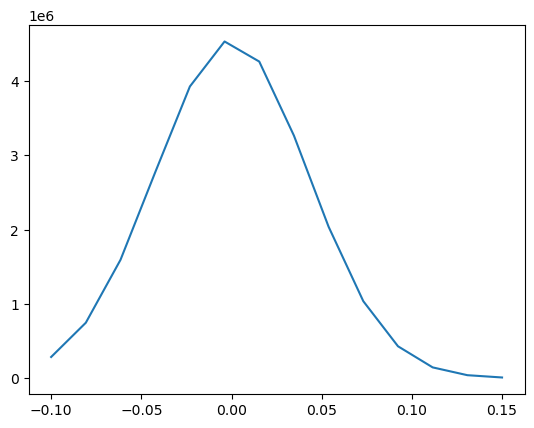

In [82]:
plt.plot(wavelength_list,intensity)

### learn np.savez   np.load 

In [60]:
np.savez("profile_0.npz",wavelength_list=wavelength_list,intensity=intensity)

In [54]:
profile=np.load("profile_0.npz")

In [57]:
profile.files

['wavelength_list', 'intensity']

In [59]:
profile["intensity"]

array([ 10865.58720952,  41462.04736504, 103139.11086749, 167251.90570218,
       176804.68625155, 121840.43106153,  54734.8574968 ,  16029.18414208,
         3060.08617439,    380.82956608])

## irradiance

In [7]:
def wavelength_shift(Tx,Ty):
    return  0.0752 * Tx**2 + 0.265*Ty
def my_Gaussian1D(x,amplitude=1, mean=0, stddev=1):
    return amplitude*math.e**(-(x-mean)**2/(2*stddev**2))

In [80]:
def irradiance(wavelength):
    total_irradiance=0
    g1 = Gaussian1D(1, 0, 0.2)
    for pixel_x in np.linspace(0,image_shape_x-1,100,dtype=int):
        for pixel_y in np.linspace(0,image_shape_y-1,100,dtype=int):
            Tx,Ty=my_offaxis_angle_rad(pixel_x,pixel_y)


            stddev=0.1*gaussian_fwhm_to_sigma
            amplitude=image_data[pixel_x][pixel_y]/(math.sqrt(2*math.pi)*stddev)
            coeff=(amplitude,  #amplitude
                   -wavelength_shift(Tx,Ty),      #mean
                   stddev)    #stddev

            total_irradiance+=my_Gaussian1D(wavelength,*coeff)
    return total_irradiance

In [35]:
a=irradiance(np.array([0,0.1]))
irradiance(0.1)

11910.82605838625

In [36]:
a

array([182030.30446644,  11910.82605839])

In [37]:
b=irradiance([0,0.1])

In [38]:
b

array([182030.30446644,  11910.82605839])

## prepare my_offaxis_angle_rad

### get the standard pixel_to_world transition

In [9]:
image_shape_x,image_shape_y=m_aia.data.shape
approximation_points_num=100
x_pixel_list=np.linspace(0,image_shape_x,approximation_points_num)
y_pixel_list=np.linspace(0,image_shape_y,approximation_points_num)
standard_Tx_list=np.zeros((approximation_points_num**2,1))
standard_Ty_list=np.zeros((approximation_points_num**2,1))

point_list=np.zeros((approximation_points_num**2, 2))
i=0

for x_pixel in x_pixel_list:
    for y_pixel in y_pixel_list:
        point_list[i]=x_pixel,y_pixel
        standard_Tx_list[i],standard_Ty_list[i]=offaxis_angle_rad(x_pixel,y_pixel)
        i+=1


### get coeff

In [10]:
def func_Tx(x, y, p):
    a,b,c=p
    return a*x+b*y+c

def func_Ty(x, y, p):
    a,b,c=p
    return a*x+b*y+c

def residuals_Tx(p, Tx, x , y ):
    """ 
    得到数据 z 和拟合函数之间的差
    """
    return Tx - func_Tx(x , y , p)

def residuals_Ty(p, Ty, x , y ):
    """ 
    得到数据 z 和拟合函数之间的差
    """
    return Ty - func_Ty(x , y , p)

In [100]:
x=point_list[:,0]
y=point_list[:,1]
Tx=standard_Tx_list
Tx=Tx.reshape(approximation_points_num**2,)
Ty=standard_Ty_list
Ty=Ty.reshape(approximation_points_num**2,)

plsq_Tx = optimize.leastsq(residuals_Tx, np.array([0, 0, 0]), args=(Tx, x , y ))  # 最小二乘法拟合
plsq_Ty = optimize.leastsq(residuals_Ty, np.array([0, 0, 0]), args=(Ty, x , y ))  # 最小二乘法拟合


In [102]:
plsq_Tx[0]

array([ 2.90965330e-06,  6.67369481e-09, -5.98777934e-03])

In [12]:
print(plsq_Tx)
print(plsq_Ty)

(array([ 2.90965330e-06,  6.67369481e-09, -5.98777934e-03]), 3)
(array([-6.67369511e-09,  2.90963570e-06, -5.87289722e-03]), 2)


In [92]:
#approximation_points_num=100:
plsq_Tx=np.array([ 2.90965330e-06,  6.67369481e-09, -5.98777934e-03])
plsq_Ty=np.array([-6.67369511e-09,  2.90963570e-06, -5.87289722e-03])

In [93]:
np.savez("plsq",plsq_Tx=plsq_Tx,plsq_Ty=plsq_Ty)

In [94]:
test=np.load("plsq.npz")
test.files

['plsq_Tx', 'plsq_Ty']

In [97]:
test["plsq_Tx"]

array([ 2.90965330e-06,  6.67369481e-09, -5.98777934e-03])

In [90]:
a

2

## my_offaxis_angle_rad

In [13]:
def my_offaxis_angle_rad(pixel_x,pixel_y):
    """
    

    Parameters
    ----------
    pixel_x : The X component of the pixel position in the image
    
    pixel_y : The Y component of the pixel position in the image
            Image size: 4096*4096
            
    Returns
    -------
    Coordinates in the Helioprojective Cartesian (HPC), which is observer-based:
    
    Tx :  angle relative to the plane containing the Sun-observer line 
        and the Sun’s rotation axis, 
        with positive values in the direction of the Sun’s west limb.
        
    Ty : angle relative to the Sun’s equatorial plane, 
        with positive values in the direction of the Sun’s north pole.

    """
   
    Tx=plsq_Tx[0][0]*pixel_x+plsq_Tx[0][1]*pixel_y+plsq_Tx[0][2]
    Ty=plsq_Ty[0][0]*pixel_x+plsq_Ty[0][1]*pixel_y+plsq_Ty[0][2]

    return Tx,Ty

In [98]:
offaxis_angle_rad

<function __main__.offaxis_angle_rad(pixel_x, pixel_y)>

In [110]:
def a(b,f):
    b+sum(f)


In [111]:
e=(3,5)
a(1,*e)

In [112]:
math.pi/360

0.008726646259971648